In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook


In [2]:
hgnc = pd.read_csv('../../data/hgnc_alias_list.txt', sep='\t')
hgnc.head()

hgnc = hgnc[hgnc['Approved symbol'].apply(lambda x: 'withdrawn' not in x)]

# get the original keys
hgnc_original_keys = hgnc['Approved symbol'].unique()

# drop a lot of columns for efficiency
hgnc = hgnc[list(hgnc.columns)[0:6]].drop('Status', axis=1)

# filter out Nan synonyms (not helpful)
hgnc_syn_list = hgnc[~ hgnc.Synonyms.isna()]
hgnc_prev_symb_list = hgnc[~ hgnc['Previous symbols'].isna()]

print(hgnc_syn_list.shape)
print(hgnc_syn_list.columns)
display(hgnc_syn_list.head())

print(hgnc_prev_symb_list.shape)
print(hgnc_prev_symb_list.columns)
display(hgnc_prev_symb_list.head())

#convert the synonyms column to a list
# convert these lists to pd.Series
# merge with original dataframe
#drop old synonyms column 
# melt the new columns into rows


current_syn_list = hgnc_syn_list.Synonyms.apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(["Synonyms"], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols'], value_name = "synonym") 

current_syn_list = current_syn_list[~ current_syn_list.synonym.isna()]
current_syn_list.synonym = current_syn_list.synonym.apply(lambda x: x.replace(' ',''))

prev_symb_list = hgnc_prev_symb_list['Previous symbols'].apply(lambda x: x.split(',')) \
    .apply(pd.Series) \
    .merge(hgnc, left_index = True, right_index = True) \
    .drop(['Previous symbols'], axis = 1) \
    .melt(id_vars = ['HGNC ID', 'Approved symbol', 'Approved name', 'Synonyms'], value_name = "synonym") 

prev_symb_list = prev_symb_list[~ prev_symb_list.synonym.isna()]
prev_symb_list.synonym = prev_symb_list.synonym.apply(lambda x: x.replace(' ',''))


hgnc_mapper = dict(zip(current_syn_list['synonym'], current_syn_list['Approved symbol']))
# add in HGNC ID mapper
hgnc_mapper.update(dict(zip(current_syn_list['HGNC ID'], current_syn_list['Approved symbol'])))
hgnc_mapper_previous = dict(zip(prev_symb_list['synonym'], prev_symb_list['Approved symbol']))

trouble_list = list(filter(lambda x: hgnc_mapper[x] != hgnc_mapper_previous[x], set(hgnc_mapper.keys())&set(hgnc_mapper_previous.keys())))

louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
for n in louvain_tier1.names:
    if (n in trouble_list):
        print(n)

hand_coded = {'RAGE':'MOK', 'SGK2':'SGK2', 'SGK196':'SGK196'}

hgnc_mapper_previous.update(hgnc_mapper) #overwrite the previous symbol conflicts

hgnc_mapper = hgnc_mapper_previous
hgnc_mapper.update({x:x for x in hgnc_original_keys}) #keep the identify maps
hgnc_mapper.update(hand_coded) # overwrite the trouble list

(21435, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
2,HGNC:24086,A1CF,APOBEC1 complementation factor,NaN,"ACF, ASP, ACF64, ACF65, APOBEC1CF"
4,HGNC:7,A2M,alpha-2-macroglobulin,NaN,"FWP007, S863-7, CPAMD5"
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"


(11702, 5)
Index(['HGNC ID', 'Approved symbol', 'Approved name', 'Previous symbols',
       'Synonyms'],
      dtype='object')


,HGNC ID,Approved symbol,Approved name,Previous symbols,Synonyms
1,HGNC:37133,A1BG-AS1,A1BG antisense RNA 1,"NCRNA00181, A1BGAS, A1BG-AS",FLJ23569
6,HGNC:23336,A2ML1,alpha-2-macroglobulin like 1,CPAMD9,"FLJ25179, p170"
9,HGNC:8,A2MP1,alpha-2-macroglobulin pseudogene 1,A2MP,NaN
12,HGNC:30005,A3GALT2,"alpha 1,3-galactosyltransferase 2",A3GALT2P,"IGBS3S, IGB3S"
13,HGNC:18149,A4GALT,"alpha 1,4-galactosyltransferase (P blood group)",P1,"A14GALT, Gb3S, P(k)"


RAGE


In [3]:
louvain_tier1 = pd.read_csv('../../results/louvain_clusters.txt', sep='\t')
louvain_tier2 = pd.read_csv('../../results/louvain_small_clusters.txt', sep='\t')

louvain_tier1.names = louvain_tier1.names.apply(lambda x: hgnc_mapper[x])
louvain_tier2.names = louvain_tier2.names.apply(lambda x: hgnc_mapper[x])

louv = louvain_tier1.merge(louvain_tier2, on='names', suffixes=['_super','_sub'])
louv.head()

,names,cluster_super,cluster_sub
0,PAK1,5,3
1,ERBB2,5,18
2,MST1R,5,18
3,YES1,5,18
4,TYRO3,5,18


In [4]:
understudied = pd.read_csv('../../data/dark_kinases.csv')
understudied.head()
#louv['']

,hgnc_id,symbol,ensembl_gene_id,class,name,uniprot_ids,kinase_com_name
0,HGNC:19038,ADCK1,ENSG00000063761,Dark,aarF domain containing kinase 1,Q86TW2,ADCK1
1,HGNC:19039,ADCK2,ENSG00000133597,Dark,aarF domain containing kinase 2,Q7Z695,ADCK2
2,HGNC:21738,ADCK5,ENSG00000173137,Dark,aarF domain containing kinase 5,Q3MIX3,ADCK5
3,HGNC:20565,ALPK2,ENSG00000198796,Dark,alpha kinase 2,Q86TB3,AlphaK2
4,HGNC:17574,ALPK3,ENSG00000136383,Dark,alpha kinase 3,Q96L96,AlphaK1


In [5]:
louv['understudied'] = louv['names'].isin(understudied['symbol'])
louv.head()

,names,cluster_super,cluster_sub,understudied
0,PAK1,5,3,False
1,ERBB2,5,18,False
2,MST1R,5,18,False
3,YES1,5,18,False
4,TYRO3,5,18,False


### Characterization Visual

In [7]:
demo_top5_positive = [('Apoptosis', 0.5),('Cell Cycle', 0.4), ('Transcription', 0.3), ('Regulation of Ribosomal RNA Transcription', .2), ('Blah', 0.05)]
demo_top3_negative = [('Meiosis', -.3), ('Sex Cell Differentiation', -.2), ('Cell Death',-.1)]

louv['top5_positive'] = [demo_top5_positive]*len(louv)
louv['top3_negative'] = [demo_top3_negative]*len(louv)

louv.head()

,names,cluster_super,cluster_sub,understudied,top5_positive,top3_negative
0,PAK1,5,3,False,"[(Apoptosis, 0.5), (Cell Cycle, 0.4), (Transcr...","[(Meiosis, -0.3), (Sex Cell Differentiation, -..."
1,ERBB2,5,18,False,"[(Apoptosis, 0.5), (Cell Cycle, 0.4), (Transcr...","[(Meiosis, -0.3), (Sex Cell Differentiation, -..."
2,MST1R,5,18,False,"[(Apoptosis, 0.5), (Cell Cycle, 0.4), (Transcr...","[(Meiosis, -0.3), (Sex Cell Differentiation, -..."
3,YES1,5,18,False,"[(Apoptosis, 0.5), (Cell Cycle, 0.4), (Transcr...","[(Meiosis, -0.3), (Sex Cell Differentiation, -..."
4,TYRO3,5,18,False,"[(Apoptosis, 0.5), (Cell Cycle, 0.4), (Transcr...","[(Meiosis, -0.3), (Sex Cell Differentiation, -..."


In [10]:
from copy import copy
filtered_louv = copy(louv[louv.cluster_sub == 6])

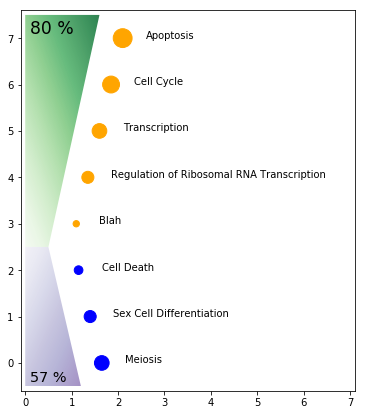

In [143]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))

num_to_plot = len(demo_top5_positive+demo_top3_negative)
acc_score = 57
prop_dark = .8

x_coords = np.ones(num_to_plot)+np.abs([(x-1)/4-.4 for x in range(num_to_plot)])
y_coords = [i for i,val in enumerate(demo_top5_positive+demo_top3_negative)]
sizes = 5+700*(np.abs([y for x,y in sorted(demo_top5_positive+demo_top3_negative, reverse=False, key=lambda x: x[1])]))
colors = ['blue']*len(demo_top3_negative) + ['orange']*len(demo_top5_positive)

ax.scatter(x=x_coords, y=y_coords, s=sizes, c=colors, zorder=1)

for i, (annot, score) in enumerate(sorted(demo_top5_positive+demo_top3_negative, reverse=False, key=lambda x: x[1])):
    ax.annotate(xy=(x_coords[i]+.5, i), s=annot)
    continue

### draw the dark quadrilateral

ax.set_ylim(-.6,7.6)
ax.set_xlim(-.1,7.1)

tri_vert_path = Path([(1.6,7.5),(.5,2.5),(0,2.5),(0,7.5),(1.6,7.5)])
tri = PathPatch(tri_vert_path, facecolor='none', edgecolor='none')
ax.add_patch(tri) 
mesh_base, mesh_grad = np.meshgrid(np.linspace(0,1), np.linspace(0,1))
im = ax.imshow(mesh_base-mesh_grad, interpolation='lanczos', cmap=plt.cm.Greens, origin='upper', extent=[0, 2, 2, 7.5],clip_path=tri, clip_on=True, alpha=prop_dark)
im.set_clip_path(tri)

ax.annotate(s=str(int(prop_dark*100))+' %', xy=(.1, 7.1), fontsize='xx-large', fontname='Helvetica')

### draw the accuracy quadrilateral


acc_vert_path = Path([(1.2,-.5),(.5,2.5),(0,2.5),(0,-.5),(1.2,-.5)])
acc = PathPatch(acc_vert_path, facecolor='none', edgecolor='none')
ax.add_patch(acc) 
mesh_base, mesh_grad = np.meshgrid(np.linspace(0,1), np.linspace(0,1))
im = ax.imshow(mesh_base-mesh_grad, interpolation='lanczos', cmap=plt.cm.Purples, origin='lower', extent=[0, 2, -.5, 4],clip_path=acc, clip_on=True, alpha=acc_score/100.)
im.set_clip_path(acc)

ax.annotate(s=str(acc_score)+' %', xy=(.1, -.4), fontsize='x-large', fontname='Helvetica')

plt.show()

#plt.show()

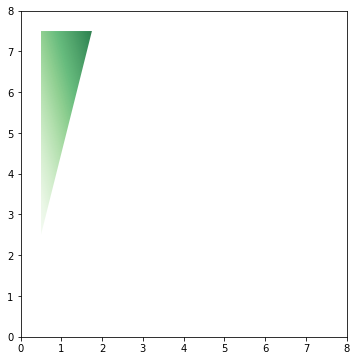

In [99]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

prop_dark = .8
tri_vert_path = Path([(1.75,7.5),(.5,2.5),(.5,7.5),(1.75,7.5)])
tri = PathPatch(tri_vert_path, facecolor='none', edgecolor='none')
ax.add_patch(tri) 
mesh_base, mesh_grad = np.meshgrid(np.linspace(0,1), np.linspace(0,1))
im = ax.imshow(mesh_base-mesh_grad, interpolation='lanczos', cmap=plt.cm.Greens, origin='upper', extent=[0.5, 2, 2, 7.5],clip_path=tri, clip_on=True, alpha=prop_dark)
im.set_clip_path(tri)

ax.set_xlim(0,8)
ax.set_ylim(0,8)

plt.show()